In [ ]:
!pip install prophet lazypredict pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import *
from sklearn.linear_model import OrthogonalMatchingPursuit
from prophet import Prophet
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# 0.Carga y exploración del dataset

Fuente de los datos: https://www.kaggle.com/datasets/ramkrijal/agriculture-vegetables-fruits-time-series-prices?select=kalimati_tarkari_dataset.csv

Lecturas recomendadas:

https://machinelearningmastery.com/multi-output-regression-models-with-python/

https://scikit-learn.org/stable/modules/multiclass.html

In [ ]:
# Cargamos el dataset de frutas y vegetales
df = pd.read_csv('kalimati_tarkari_dataset.csv')
df.head()

,SN,Commodity,Date,Unit,Minimum,Maximum,Average
0,0,Tomato Big(Nepali),2013-06-16,Kg,35.00,40.00,37.50
1,1,Tomato Small(Local),2013-06-16,Kg,26.00,32.00,29.00
2,2,Potato Red,2013-06-16,Kg,20.00,21.00,20.50
3,3,Potato White,2013-06-16,Kg,15.00,16.00,15.50
4,4,Onion Dry (Indian),2013-06-16,Kg,28.00,30.00,29.00


In [ ]:
# Total de registros y columnas
df.shape

(197161, 7)

In [ ]:
# Tipología de las columnas
df.dtypes

SN             int64
Commodity     object
Date          object
Unit          object
Minimum      float64
Maximum      float64
Average      float64
dtype: object

In [ ]:
# Comprobamos valores faltantes
df.isna().sum()

SN           0
Commodity    0
Date         0
Unit         0
Minimum      0
Maximum      0
Average      0
dtype: int64

In [ ]:
# Comprobamos duplicados
df.duplicated().sum()

0

In [ ]:
# Comprobamos los valores únicos de cada columna
df.nunique()

SN           197161
Commodity       132
Date           2753
Unit              4
Minimum         198
Maximum         205
Average         384
dtype: int64

In [ ]:
# Tipos de unidades
df.Unit.value_counts()

Kg      184408
KG        6889
1 Pc      3120
Doz       2744
Name: Unit, dtype: int64

In [ ]:
# Seleccionar productos cuyo precio está referido a kilogramos y las columnas Commodity, Date, Average
df = df[df.Unit.isin(['Kg', 'KG'])][['Commodity', 'Date', 'Average']]
df.head()

,Commodity,Date,Average
0,Tomato Big(Nepali),2013-06-16,37.50
1,Tomato Small(Local),2013-06-16,29.00
2,Potato Red,2013-06-16,20.50
3,Potato White,2013-06-16,15.50
4,Onion Dry (Indian),2013-06-16,29.00


In [ ]:
# Convertimos el tipo de la columna Date a Datetime
df.Date = pd.to_datetime(df.Date)
print(f'Total de dias teóricos que componen la serie temporal: {(df.Date.max()-df.Date.min()).days}')
print(f'Total de dias para los que se tiene registros: {len(set(df.Date))}')
print(f'Faltan registros para {(df.Date.max()-df.Date.min()).days-len(set(df.Date))} dias.')

Total de dias teóricos que componen la serie temporal: 2888
Total de dias para los que se tiene registros: 2753
Faltan registros para 135 dias.


In [ ]:
# De cuántos productos tenemos registros
conteos = df.Commodity.value_counts()
conteos

Ginger                  2751
Cauli Local             2750
Cabbage(Local)          2749
Chilli Dry              2748
Raddish White(Local)    2747
                        ... 
Litchi(Indian)            41
Mango(Calcutte)           23
Sweet Lime                14
Musk Melon                10
Mango(Chousa)              2
Name: Commodity, Length: 128, dtype: int64

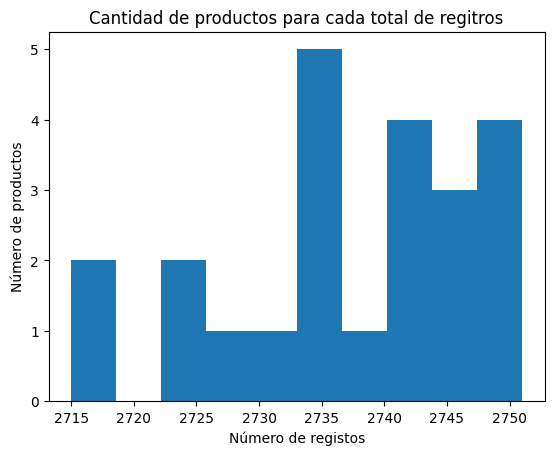

In [ ]:
plt.hist(conteos.values[conteos.values>2700])
plt.title('Cantidad de productos para cada total de regitros')
plt.ylabel('Número de productos')
plt.xlabel('Número de registos')
plt.show()

In [ ]:
conteos[conteos>2700]

Ginger                  2751
Cauli Local             2750
Cabbage(Local)          2749
Chilli Dry              2748
Raddish White(Local)    2747
Potato Red              2746
Bamboo Shoot            2744
Brd Leaf Mustard        2742
Onion Dry (Indian)      2742
Coriander Green         2741
Tomato Small(Local)     2741
French Bean(Local)      2739
Brinjal Long            2736
Carrot(Local)           2736
Chilli Green            2735
Onion Green             2735
Spinach Leaf            2733
Mushroom(Kanya)         2730
Garlic Dry Chinese      2728
Capsicum                2725
Lime                    2725
Tamarind                2715
Pumpkin                 2715
Name: Commodity, dtype: int64

In [ ]:
df = df[df.Commodity.isin(conteos[conteos>2700].index)]

In [ ]:
df.head()

,Commodity,Date,Average
1,Tomato Small(Local),2013-06-16,29.00
2,Potato Red,2013-06-16,20.50
4,Onion Dry (Indian),2013-06-16,29.00
5,Carrot(Local),2013-06-16,32.50
6,Cabbage(Local),2013-06-16,8.00


Tenemos un total de 132 produtos el total de registros para cada producto varía. Para este ejemplo vamos a trabajar con el producto para el cual su precio pueda verse condicionado por la variable tiempo y que además tengamos suficientes registros "Tomato Small(Local)".

In [ ]:
df_one = df[df.Commodity=='Tomato Small(Local)'][['Date','Average']]

In [ ]:
# El intervalo de fechas teórico sería
rango_fechas = pd.date_range(start=df_one.Date.min(), end=df_one.Date.max())
rango_fechas

DatetimeIndex(['2013-06-16', '2013-06-17', '2013-06-18', '2013-06-19',
               '2013-06-20', '2013-06-21', '2013-06-22', '2013-06-23',
               '2013-06-24', '2013-06-25',
               ...
               '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07',
               '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11',
               '2021-05-12', '2021-05-13'],
              dtype='datetime64[ns]', length=2889, freq='D')

In [ ]:
# Crear un DataFrame con las fechas completas
df_final = pd.merge(pd.DataFrame({'Date_Complete': rango_fechas}), df_one, how='left', left_on='Date_Complete', right_on='Date').drop('Date', axis=1)

In [ ]:
df_final.isna().sum()

Date_Complete      0
Average          148
dtype: int64

Faltan registros para 148 días, comprobaremos si existe un patrón de ausencia.

In [ ]:
# Valores faltantes para cada año
print(Counter([pd.to_datetime(fecha).year for fecha in df_final[df_final.Average.isna()].Date_Complete.values]))

Counter({2014: 54, 2013: 43, 2020: 17, 2015: 13, 2017: 12, 2021: 3, 2016: 2, 2018: 2, 2019: 2})


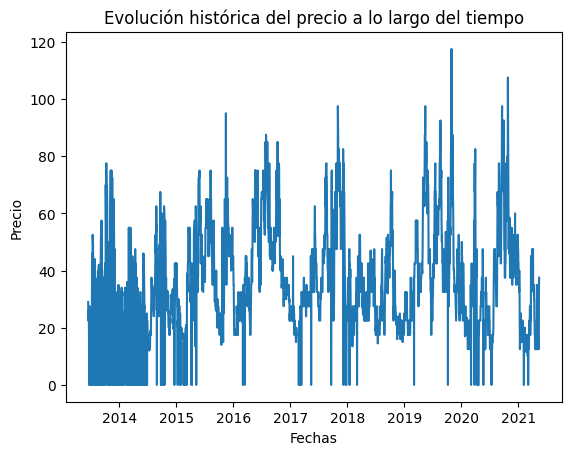

In [ ]:
# Ponemos a 0 los valores faltantes para detectar el patrón de ausencia en la serie
df_aux = df_final.fillna(0)
plt.plot(df_aux['Date_Complete'], df_aux['Average'])
plt.xlabel('Fechas')
plt.ylabel('Precio')
plt.title('Evolución histórica del precio a lo largo del tiempo')
plt.show()

Entre 2013 y 2014 vemos que nos faltan registros de algo más de 3 meses, por lo que vamos a trabajar con los datos que se tienen a partir de 2015.

In [ ]:
df_final = df_final[df_final.Date_Complete>=pd.to_datetime('2015-01-01')]
df_final.head()

,Date_Complete,Average
564,2015-01-01,34.00
565,2015-01-02,37.50
566,2015-01-03,42.50
567,2015-01-04,33.00
568,2015-01-05,35.00


In [ ]:
# Imputamos los valores faltantes con la media entre el registro anterior y posterior
df_final['Average'] = df_final['Average'].fillna((df_final['Average'].ffill() + df_final['Average'].bfill()) / 2)

In [ ]:
df_final.isna().sum()

Date_Complete    0
Average          0
dtype: int64

In [ ]:
# Indexamos usando la fecha
df_final.set_index('Date_Complete', inplace=True, drop=True)
df_final.head()

,Average
Date_Complete,
2015-01-01,34.00
2015-01-02,37.50
2015-01-03,42.50
2015-01-04,33.00
2015-01-05,35.00


In [ ]:
df_final.iloc[:-365]

,Average
Date_Complete,
2015-01-01,34.00
2015-01-02,37.50
2015-01-03,42.50
2015-01-04,33.00
2015-01-05,35.00
...,...
2020-05-09,27.50
2020-05-10,32.50
2020-05-11,37.50


# 1.Forecasting a un paso vista con walk-forward validation

In [ ]:
# Rompemos el dataset en conjunto de entrenamiento y conjunto de prueba (los últimos 365 días)
df_train, df_test = df_final.iloc[:-365], df_final.iloc[-365:]

In [ ]:
# Definimos la variable ts para referirnos a nuestra serie temporal
ts = df_final['Average']
ts

Date_Complete
2015-01-01   34.00
2015-01-02   37.50
2015-01-03   42.50
2015-01-04   33.00
2015-01-05   35.00
              ... 
2021-05-09   12.50
2021-05-10   12.50
2021-05-11   12.50
2021-05-12   32.50
2021-05-13   37.50
Name: Average, Length: 2325, dtype: float64

In [ ]:
# Split the dataset into segments of length 4
n = 4
XY_train = np.array([df_train[i:i+n].Average.values for i in range(len(df_train)) if len(df_train[i:i+n])==n])
X_train , y_train = XY_train[:,:-1], XY_train[:,-1]
XY_test = np.array([df_test[i:i+n].Average.values for i in range(len(df_test)) if len(df_test[i:i+n])==n])
X_test , y_test = XY_test[:,:-1], XY_test[:,-1]

In [ ]:
X_train

array([[34. , 37.5, 42.5],
       [37.5, 42.5, 33. ],
       [42.5, 33. , 35. ],
       ...,
       [27.5, 27.5, 32.5],
       [27.5, 32.5, 37.5],
       [32.5, 37.5, 37.5]])

In [ ]:
df_train[0:4].Average.values

array([34. , 37.5, 42.5, 33. ])

In [ ]:
# Crear el modelo de regresión lineal
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const)

# Ajustar el modelo a los datos
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     5103.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:50:52   Log-Likelihood:                -6181.0
No. Observations:                1957   AIC:                         1.237e+04
Df Residuals:                    1953   BIC:                         1.239e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0695      0.333      6.215      0.0

In [ ]:
reg = LazyRegressor()
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:06<00:00,  6.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 1957, number of used features: 3
[LightGBM] [Info] Start training from score 39.235692


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
OrthogonalMatchingPursuit,0.90,0.91,6.17,0.01
OrthogonalMatchingPursuitCV,0.90,0.91,6.18,0.02
HuberRegressor,0.90,0.91,6.18,0.02
Lars,0.90,0.90,6.19,0.02
LassoLarsIC,0.90,0.90,6.19,0.01
TransformedTargetRegressor,0.90,0.90,6.19,0.02
LinearRegression,0.90,0.90,6.19,0.01
LarsCV,0.90,0.90,6.19,0.04
LassoLarsCV,0.90,0.90,6.19,0.01


In [ ]:
model = OrthogonalMatchingPursuit().fit(X_train , y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print(r2_score(y_train,y_pred_train), mean_absolute_percentage_error(y_train,y_pred_train)*100, mean_absolute_error(y_train,y_pred_train))
print(r2_score(y_test,y_pred_test), mean_absolute_percentage_error(y_test,y_pred_test)*100, mean_absolute_error(y_test,y_pred_test))

0.8862725964525207 9.998438499395037 3.740985096833345
0.9054034692738012 13.916228597431157 4.318511820253722


In [ ]:
def wf_validation(X_train , y_train, X_test , y_test):
  y_pred = []
  for i in range(len(y_test)):
    y_pred.append(OrthogonalMatchingPursuit().fit(X_train, y_train).predict(np.array([X_test[i]]))[0])
    X_train, y_train = np.vstack((X_train, X_test[i])), np.hstack((y_train, y_test[i]))
  return np.array(y_pred)

y_pred = wf_validation(X_train , y_train, X_test , y_test)

In [ ]:
print(r2_score(y_test,y_pred), mean_absolute_percentage_error(y_test,y_pred)*100, mean_absolute_error(y_test,y_pred))

0.9053059484080932 13.83938691428536 4.310470783971033


# 2.Forecasting con Prophet

In [ ]:
# Ajustamos un modelo de Prophet con el dataframe creado para la serie temporal
model = Prophet().fit(pd.DataFrame({'ds': df_train.Average.index, 'y': df_train.Average.values}))
# Creamos un df que contendrá las predicciones
df_future = model.make_future_dataframe(periods=len(y_test), freq='d')
# Realizamos la predicción
forecast = model.predict(df_future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0qraelkf/d2g8w4i4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0qraelkf/a6j52e5c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28245', 'data', 'file=/tmp/tmp0qraelkf/d2g8w4i4.json', 'init=/tmp/tmp0qraelkf/a6j52e5c.json', 'output', 'file=/tmp/tmp0qraelkf/prophet_model1bl0rgev/prophet_model-20231117153302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:33:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,38.01,11.08,42.43,38.01,38.01,-11.19,-11.19,-11.19,-0.49,-0.49,-0.49,-10.69,-10.69,-10.69,0.00,0.00,0.00,26.82
1,2015-01-02,38.02,11.10,45.09,38.02,38.02,-10.72,-10.72,-10.72,0.01,0.01,0.01,-10.73,-10.73,-10.73,0.00,0.00,0.00,27.30
2,2015-01-03,38.03,10.62,43.65,38.03,38.03,-11.07,-11.07,-11.07,-0.33,-0.33,-0.33,-10.74,-10.74,-10.74,0.00,0.00,0.00,26.96
3,2015-01-04,38.04,11.82,43.47,38.04,38.04,-10.36,-10.36,-10.36,0.37,0.37,0.37,-10.73,-10.73,-10.73,0.00,0.00,0.00,27.68
4,2015-01-05,38.05,9.68,44.21,38.05,38.05,-10.28,-10.28,-10.28,0.43,0.43,0.43,-10.72,-10.72,-10.72,0.00,0.00,0.00,27.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317,2021-05-06,39.45,23.36,58.44,31.93,47.59,1.75,1.75,1.75,-0.49,-0.49,-0.49,2.24,2.24,2.24,0.00,0.00,0.00,41.19
2318,2021-05-07,39.44,23.97,61.96,31.88,47.64,3.12,3.12,3.12,0.01,0.01,0.01,3.11,3.11,3.11,0.00,0.00,0.00,42.57
2319,2021-05-08,39.44,24.51,62.01,31.86,47.69,3.63,3.63,3.63,-0.33,-0.33,-0.33,3.97,3.97,3.97,0.00,0.00,0.00,43.07
2320,2021-05-09,39.43,27.27,64.09,31.82,47.72,5.18,5.18,5.18,0.37,0.37,0.37,4.81,4.81,4.81,0.00,0.00,0.00,44.61


In [ ]:
yhat_test_pro = forecast.yhat[-len(y_test):]

In [ ]:
print(r2_score(y_test,yhat_test_pro), mean_absolute_percentage_error(y_test,yhat_test_pro)*100, mean_absolute_error(y_test,yhat_test_pro))

0.11615071261535626 60.85815206624721 14.70275888398295


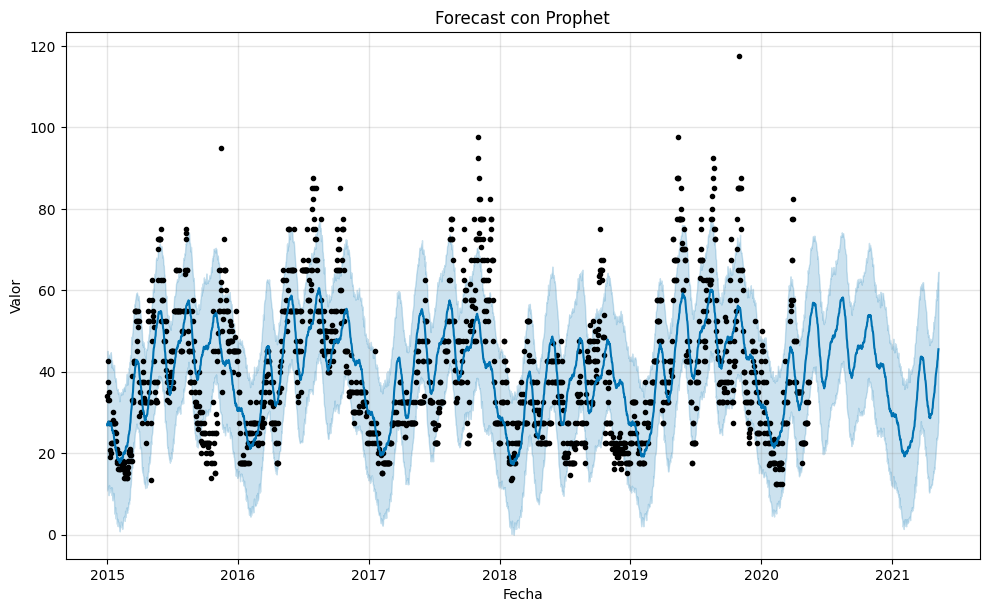

In [ ]:
# Graficar el forecast
model.plot(forecast)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Forecast con Prophet')
plt.show()

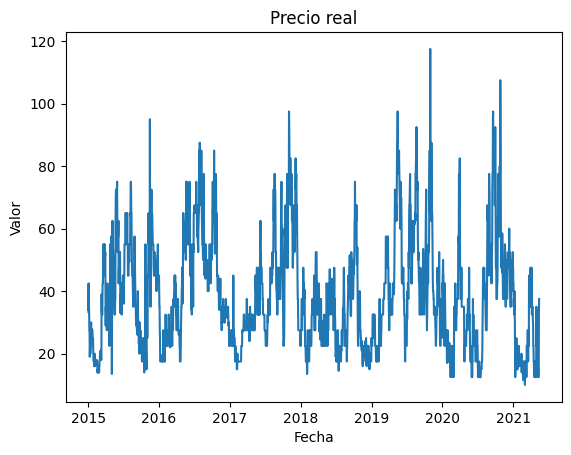

In [ ]:
plt.plot(df_final.Average)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Precio real')
plt.show()

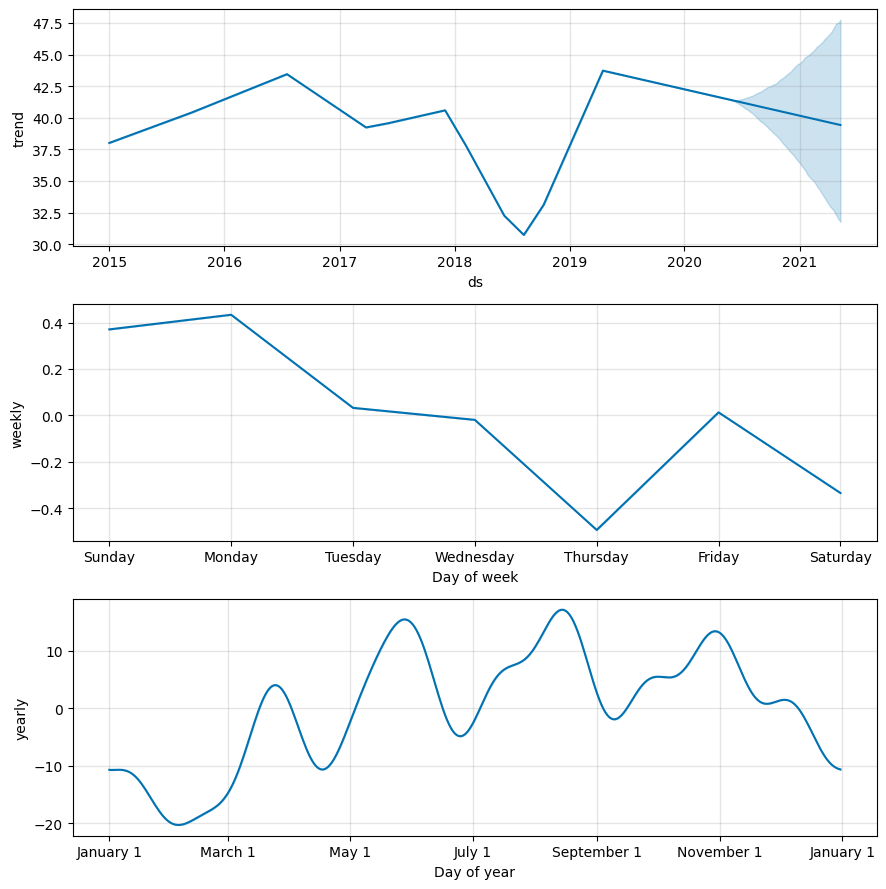

In [ ]:
# Descomponer la serie y visualizar las componentes
model.plot_components(forecast)
plt.show()

# 3.Multioutput forecasting

In [ ]:
# Considerar el tamaño del input y del output
in_len, out_len = 7, 2
n = in_len+out_len
XY_train = np.array([df_train[i:i+n].Average.values for i in range(len(df_train)) if len(df_train[i:i+n])==n])
X_train , y_train = XY_train[:,:in_len], XY_train[:,-out_len:]
XY_test = np.array([df_test[i:i+n].Average.values for i in range(len(df_test)) if len(df_test[i:i+n])==n])
X_test , y_test = XY_test[:,:in_len], XY_test[:,-out_len:]

In [ ]:
X_train

array([[34. , 37.5, 42.5, ..., 35. , 33. , 27.5],
       [37.5, 42.5, 33. , ..., 33. , 27.5, 27.5],
       [42.5, 33. , 35. , ..., 27.5, 27.5, 19. ],
       ...,
       [27.5, 27.5, 27.5, ..., 27.5, 27.5, 27.5],
       [27.5, 27.5, 32.5, ..., 27.5, 27.5, 32.5],
       [27.5, 32.5, 27.5, ..., 27.5, 32.5, 37.5]])

In [ ]:
y_train

array([[27.5 , 19.  ],
       [19.  , 20.75],
       [20.75, 22.5 ],
       ...,
       [32.5 , 37.5 ],
       [37.5 , 37.5 ],
       [37.5 , 37.5 ]])

In [ ]:
model_multi = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)).fit(X_train, y_train)
ypred_test_multi = model_multi.predict(X_test)

In [ ]:
print(r2_score(y_test,ypred_test_multi), mean_absolute_percentage_error(y_test,ypred_test_multi)*100, mean_absolute_error(y_test,ypred_test_multi))

0.8414727901644783 21.23357984880617 5.9331413161268625


In [ ]:
# Versión chain
model_chain = RegressorChain(GradientBoostingRegressor(random_state=0)).fit(X_train, y_train)
ypred_test_chain = model_chain.predict(X_test)
print(r2_score(y_test,ypred_test_chain), mean_absolute_percentage_error(y_test,ypred_test_chain)*100, mean_absolute_error(y_test,ypred_test_chain))

0.8390189675687658 20.62881163542551 5.904441190591702


# 4.Multi-input forecasting

In [ ]:
def get_multi_input_df(df, product):
  rango_fechas = pd.date_range(start=df.Date.min(), end=df.Date.max())
  df = pd.merge(pd.DataFrame({'Date_Complete': rango_fechas}), df, how='left', left_on='Date_Complete', right_on='Date').drop('Date', axis=1)
  df_multi = df.pivot(index='Date_Complete', columns='Commodity', values='Average').iloc[:,1:]
  df_multi = df_multi[df_multi.index>=pd.to_datetime('2015-01-01')]
  df_multi = df_multi.fillna((df_multi.ffill() + df_multi.bfill()) / 2)
  df_multi[product] = df_multi[product].shift(periods=-1)
  df_multi.dropna(inplace=True)
  X, y = df_multi.drop([product], axis=1), df_multi[product]
  X_train, y_train, X_test, y_test = X.iloc[:-365,], y.iloc[:-365], X.iloc[-365:,], y.iloc[-365:]
  return X_train, y_train, X_test, y_test

In [ ]:
for p in set(df.Commodity):
  X_train, y_train, X_test, y_test = get_multi_input_df(df,p)
  # Instanciamos el escalador y lo ajustamos a los datos de entrenamiento
  scaler = MinMaxScaler().fit(X_train)
  # Transformamos los datos de entrenamiento y testeo
  X_train_sc = scaler.transform(X_train)
  X_test_sc = scaler.transform(X_test)
  # Crear el modelo de regresión lineal
  X_train_const = sm.add_constant(X_train_sc)
  model = sm.OLS(y_train, X_train_const)
  # Ajustar el modelo a los datos
  results = model.fit()
  r2 = results.rsquared
  if r2>=0.8:
    print(p,r2)
    print('-'*50)

Chilli Dry 0.8118551318200217
--------------------------------------------------
Potato Red 0.813947804414444
--------------------------------------------------
Garlic Dry Chinese 0.8038151149748475
--------------------------------------------------


In [ ]:
X_train, y_train, X_test, y_test = get_multi_input_df(df,'Garlic Dry Chinese')
# Instanciamos el escalador y lo ajustamos a los datos de entrenamiento
scaler = MinMaxScaler().fit(X_train)
# Transformamos los datos de entrenamiento y testeo
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
# Crear el modelo de regresión lineal
X_train_const = sm.add_constant(X_train_sc)
model = sm.OLS(y_train, X_train_const)
# Ajustar el modelo a los datos
results = model.fit()
# Convertir la tabla a un DataFrame
df_coef = pd.DataFrame(results.summary().tables[1].data[1:], columns=results.summary().tables[1].data[0]).iloc[1:,:]
# Convertir los valores de P>|t| a números y filtrar por el umbral deseado (por ejemplo, 0.05)
umbral = 0.05
variables_significativas = df_coef[df_coef['P>|t|'].astype(float) < umbral].index-1
print(df_coef)
print(variables_significativas)

               coef    std err          t   P>|t|     [0.025     0.975]
1    x1     91.3098      4.799     19.027   0.000     81.898    100.722
2    x2     25.8963     16.993      1.524   0.128     -7.430     59.223
3    x3     57.9048      8.398      6.895   0.000     41.434     74.375
4    x4     69.3700     10.737      6.461   0.000     48.312     90.428
5    x5    -48.8995      9.636     -5.075   0.000    -67.797    -30.002
6    x6     36.7685     10.264      3.582   0.000     16.639     56.898
7    x7    -70.4072     14.298     -4.924   0.000    -98.448    -42.366
8    x8    451.9643     10.428     43.339   0.000    431.512    472.417
9    x9     18.7981     13.933      1.349   0.177     -8.526     46.123
10  x10    -29.9618      8.846     -3.387   0.001    -47.311    -12.612
11  x11      7.3704      6.774      1.088   0.277     -5.914     20.655
12  x12    -35.3952      7.965     -4.444   0.000    -51.017    -19.774
13  x13     46.8553     11.181      4.191   0.000     24.928    

In [ ]:
# Vamos a usar un método embebido que nos informe de la importancia de las características significativas
# Crea un modelo XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror')

# Entrena el modelo en los datos de entrenamiento
model.fit(X_train.iloc[:,variables_significativas], y_train)

# Calcula la importancia de las características
feature_importances = model.feature_importances_

# Asocia las importancias con los nombres de las características
feature_names = X_train.iloc[:,variables_significativas].columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Imprime la importancia de las características (número adimensional, las características se comparan entre sí en términos de su contribución relativa a la predicción)
ls_features = []
for i, val in enumerate(feature_importance_dict.items()):
    feature, importance = val
    print(f'Feature: {feature}, Importance: {importance}')
    if importance>=0.01:
      ls_features.append(feature)

Feature: Bamboo Shoot, Importance: 0.03146659955382347
Feature: Brinjal Long, Importance: 0.004298499319702387
Feature: Cabbage(Local), Importance: 0.0027598291635513306
Feature: Capsicum, Importance: 0.0017374182352796197
Feature: Carrot(Local), Importance: 0.010388079099357128
Feature: Cauli Local, Importance: 0.00524896988645196
Feature: Chilli Dry, Importance: 0.7052026987075806
Feature: Coriander Green, Importance: 0.0005216819699853659
Feature: Ginger, Importance: 0.010838999412953854
Feature: Lime, Importance: 0.08088863641023636
Feature: Onion Dry (Indian), Importance: 0.018090615049004555
Feature: Onion Green, Importance: 0.003749067895114422
Feature: Potato Red, Importance: 0.007371529936790466
Feature: Pumpkin, Importance: 0.0045929900370538235
Feature: Raddish White(Local), Importance: 0.00727606937289238
Feature: Spinach Leaf, Importance: 0.10225651413202286
Feature: Tamarind, Importance: 0.0033117826096713543


In [ ]:
ls_features

['Bamboo Shoot',
 'Carrot(Local)',
 'Chilli Dry',
 'Ginger',
 'Lime',
 'Onion Dry (Indian)',
 'Spinach Leaf']

In [ ]:
X_train[ls_features]

Commodity,Bamboo Shoot,Carrot(Local),Chilli Dry,Ginger,Lime,Onion Dry (Indian),Spinach Leaf
Date_Complete,,,,,,,
2015-01-01,75.00,47.50,210.00,55.00,350.00,39.00,47.50
2015-01-02,75.00,42.50,205.00,57.50,350.00,39.50,42.50
2015-01-03,75.00,47.50,205.00,55.00,350.00,39.50,47.50
2015-01-04,75.00,42.50,205.00,57.50,350.00,38.50,42.50
2015-01-05,75.00,55.00,205.00,57.50,350.00,38.50,42.50
...,...,...,...,...,...,...,...
2020-05-08,115.00,27.50,395.00,195.00,155.00,27.00,47.50
2020-05-09,115.00,27.50,395.00,195.00,125.00,27.00,47.50
2020-05-10,115.00,27.50,395.00,195.00,135.00,28.00,47.50


In [ ]:
corr = X_train[ls_features].corr()
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=corr.columns)
vif

Commodity
Bamboo Shoot         2.61
Carrot(Local)        4.05
Chilli Dry           5.15
Ginger               4.39
Lime                 4.62
Onion Dry (Indian)   3.37
Spinach Leaf         4.98
dtype: float64

In [ ]:
# Instanciamos el escalador y lo ajustamos a los datos de entrenamiento
scaler = MinMaxScaler().fit(X_train[ls_features])
# Transformamos los datos de entrenamiento y testeo
X_train_sc = scaler.transform(X_train[ls_features])
X_test_sc = scaler.transform(X_test[ls_features])

In [ ]:
# Crear el modelo de regresión lineal
X_train_const = sm.add_constant(X_train_sc)
model = sm.OLS(y_train, X_train_const)
# Ajustar el modelo a los datos
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     Garlic Dry Chinese   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     949.1
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:48:46   Log-Likelihood:                -10172.
No. Observations:                1959   AIC:                         2.036e+04
Df Residuals:                    1951   BIC:                         2.041e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -23.9063      5.623     -4.252      0.0

In [ ]:
reg = LazyRegressor()
models, predictions = reg.fit(X_train_sc, X_test_sc, y_train.values, y_test.values)

100%|██████████| 42/42 [00:07<00:00,  5.61it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1959, number of used features: 7
[LightGBM] [Info] Start training from score 219.872001


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DummyRegressor,-0.30,-0.28,58.72,0.03
SVR,-0.39,-0.36,60.65,0.28
GammaRegressor,-0.50,-0.47,63.15,0.02
NuSVR,-0.62,-0.59,65.48,0.22
TweedieRegressor,-0.93,-0.89,71.47,0.07
RANSACRegressor,-0.97,-0.93,72.24,0.14
ElasticNet,-1.36,-1.31,79.04,0.04
LinearSVR,-1.97,-1.91,88.76,0.03
PassiveAggressiveRegressor,-2.26,-2.20,93.01,0.02


# 5.Forecasting con AUTOARIMA

In [ ]:
df_train

,Average
Date_Complete,
2015-01-01,34.00
2015-01-02,37.50
2015-01-03,42.50
2015-01-04,33.00
2015-01-05,35.00
...,...
2020-05-09,27.50
2020-05-10,32.50
2020-05-11,37.50


In [ ]:
# Utilizamos auto_arima para buscar automáticamente los mejores parámetros
auto_model = auto_arima(df_train.Average, exogenous=None, seasonal=True, m=7)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1960
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -6186.043
Date:                Fri, 17 Nov 2023   AIC                          12384.087
Time:                        16:38:05   BIC                          12417.571
Sample:                    01-01-2015   HQIC                         12396.394
                         - 05-13-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5892      0.667      5.378      0.000       2.281       4.897
ar.L1          0.0969      0.061      1.588      0.112      -0.023       0.216
ar.L2          0.8115      0.058     14.084      0.0

In [ ]:
forecast = auto_model.predict(len(df_test))

In [ ]:
forecast

2020-05-14   37.47
2020-05-15   37.67
2020-05-16   37.65
2020-05-17   37.80
2020-05-18   37.80
              ... 
2021-05-09   39.17
2021-05-10   39.17
2021-05-11   39.17
2021-05-12   39.17
2021-05-13   39.17
Freq: D, Length: 365, dtype: float64

In [ ]:
y_test = df_test.Average.values
y_pred = forecast.values

In [ ]:
print(r2_score(y_test,y_pred), mean_absolute_percentage_error(y_test,y_pred)*100, mean_absolute_error(y_test,y_pred))

-0.028077497959995812 71.55558947291765 16.792852211057472
